Notebook pour étudier la propagation/addition des erreurs entre le RNN TPDN

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# from  GRU import GRUEncoderGD, GRUDecoderGD
# from TPDN import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')
    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
class GRUEncoderGD(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=self.num_layers)


    def forward(self, sequence):
        embedded = self.embedding(sequence)  # (batch_size, seq_len, emb_size)
        output, hidden = self.rnn(embedded)  # hidden contient le dernier état caché et output la suite de tous les états cachés
        # hidden : num_layers x batchsize x emb_size
        return output, hidden

class GRUDecoderGD(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 5
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, hidden, output_len):
        """
        hidden : Dernier état caché de l'encodeur (num_layers, batch_size, hidden_dim).
        """
        batch_size = hidden.size(1)
        outputs = []
        input_t = torch.zeros(batch_size, 1, self.hidden_size)  # entrée initiale
        for _ in range(output_len):
            output, hidden = self.rnn(input_t, hidden)
            output = self.out(output)  # (batch_size, 1, output_size)
            output = self.softmax(output)
            outputs.append(output.squeeze(1))  # (batch_size, output_size)
        return torch.stack(outputs, dim=1)  # (batch_size, seq_len, output_size)




In [67]:
class TensorProductEncoder(nn.Module):
    def __init__(self, n_roles, n_fillers, filler_dim, role_dim, hidden_size):
        super().__init__()

        self.n_roles = n_roles
        self.n_fillers = n_fillers
        self.filler_dim = filler_dim  # dimension des embeddings des fillers
        self.role_dim = role_dim  # dimension des embeddings des rôles

        self.hidden_size = hidden_size  # taille du vecteur caché final

        # Embedding pour les fillers et les rôles
        self.filler_embedding = nn.Embedding(self.n_fillers, self.filler_dim)
        self.role_embedding = nn.Embedding(self.n_roles, self.role_dim)

        # Couche linéaire pour adapter la sortie du produit tensoriel à la taille cachée attendue
        self.last_layer = nn.Linear(self.filler_dim * self.role_dim, self.hidden_size)

    def forward(self, filler_list, role_list):
        fillers_embedded = self.filler_embedding(filler_list)  # (batch_size, seq_len, filler_dim)
        roles_embedded = self.role_embedding(role_list)  # (batch_size, seq_len, role_dim)

        #  stocker les différentes sorties 
        batch_size = fillers_embedded.size(0)
        seq_len = fillers_embedded.size(1)
        final_states = torch.zeros(batch_size, seq_len, self.hidden_size)



        for i in range(fillers_embedded.size(1)):  # itérer sur chaque élément de la séquence
 
            fillers_expanded = fillers_embedded[:, i].unsqueeze(-1)  # (batch_size, filler_dim, 1)
            roles_expanded = roles_embedded[:, i].unsqueeze(-2)  # (batch_size, 1, role_dim)
            
            tensor_product = torch.matmul(fillers_expanded, roles_expanded)  # (batch_size, filler_dim, role_dim)
            

            tensor_product_flattened = tensor_product.view(tensor_product.size(0), -1)  # (batch_size, filler_dim * role_dim)
            

            final_state = self.last_layer(tensor_product_flattened)  # (batch_size, hidden_size)
            
     
            final_states[:, i, :] = final_state

        # final_states est maintenant une liste des états finaux pour chaque étape
        # Le dernier élément est l'état final correspondant à la séquence complète
        return final_states


using cpu 
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
Epoch [10/10000], Loss: 2.3047, Accuracy: 8.44%
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
Epoch [20/10000], Loss: 2.3007, Accuracy: 12.34%
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
Epoch [30/10000], Loss: 2.3000, Accuracy: 12.66%
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
torch.Size([5, 64, 16])
tor

FileNotFoundError: [Errno 2] No such file or directory: '/home/baptiste/Documents/cours/projet_3A/partie1/resultats/GD/training_gru_10000_epochs.png'

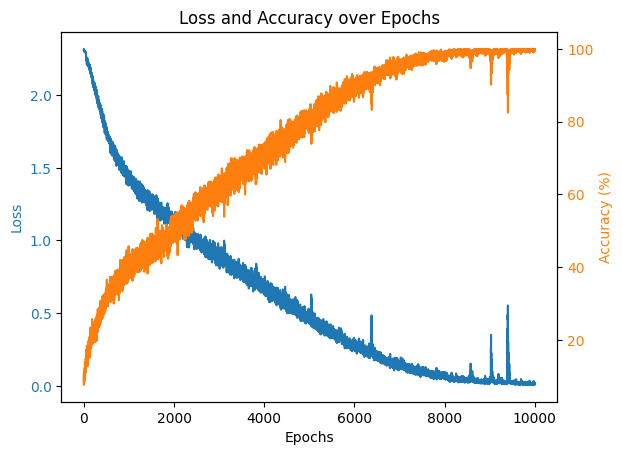

In [27]:

input_size = 10
emb_size = 5
hidden_size = 16
output_size = 10
num_layers = 5
batch_size = 64
seq_len = 10
epochs = 10000
learning_rate = 0.001

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print( f"using {device} ")
encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers).to(device)
decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapté pour des classes discrètes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    data , _ = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    

    _, hidden = encoder(data)
    # print(hidden.shape)
    # hidden = hidden[-1]
    # print(hidden.shape)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, data)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")



# torch.save(encoder, "./models/GD/gru_enc.pth")
# torch.save(decoder, "./models/GD/gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title('Loss and Accuracy over Epochs')

# plt.savefig(f"./resultats/GD/training_gru_{epochs}_epochs.png")
plt.show()

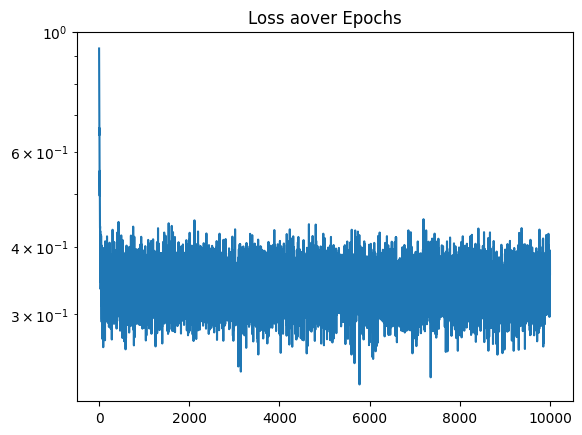

In [73]:

seq_len_tensor = torch.tensor([seq_len])


tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)



criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

encoder.eval()
tpdnencoder.train()
losses = []
for epoch in range(epochs):

    data, roles = generate_data(batch_size, seq_len, input_size)

    _ , encoder_hidden = encoder(data)
    # print(encoder_hidden.shape)
    encoder_hidden = encoder_hidden[-1,:,:]
    # print(encoder_hidden.shape)
    tpdn_output = tpdnencoder(data, roles)[:,-1,:]
    # print(tpdn_output.shape)
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)
    loss = criterion(encoder_hidden, tpdn_output)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# torch.save(tpdnencoder, "./models/GD/tpdn_gru.pth")


plt.plot(losses)
plt.yscale('log')
plt.title('Loss aover Epochs')
plt.show()



torch.Size([1, 10, 16])
torch.Size([5, 1, 16])
torch.Size([1, 16])
torch.Size([1, 10, 16])
tensor([[ 0.9784, -1.0000, -0.9999, -0.4016, -1.0000,  0.1271,  0.9019, -0.3940,
         -0.9483,  1.0000, -1.0000, -1.0000, -0.7630,  0.9506,  0.9999,  0.9878]],
       grad_fn=<SelectBackward0>)
tensor([[ 0.4477, -0.7021, -0.8406, -0.1428, -0.9208,  0.7207,  0.4518, -0.4691,
         -0.3311,  0.7662, -0.9329, -0.8500,  0.1860,  0.6818,  0.7919,  0.4366]],
       grad_fn=<SliceBackward0>)


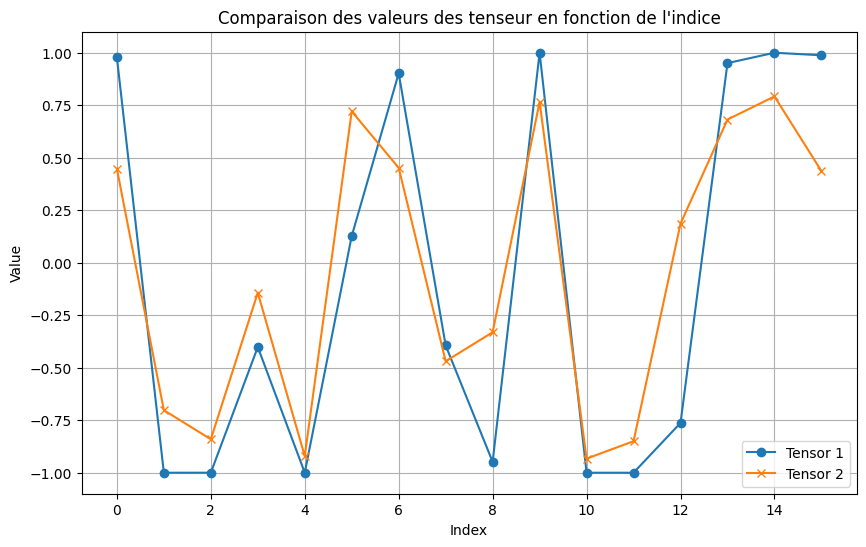

In [76]:
data , roles = generate_data(1, seq_len, input_size)

rnn_out, rnn_hidden = encoder(data)
tpdn_output= tpdnencoder(data, roles)
# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:]

print( rnn_out.shape)
print(rnn_hidden.shape)
print(tpdn_hidden.shape)
print(tpdn_output.shape)

print(rnn_hidden[-1])
print(tpdn_hidden)
plot_tensors(rnn_hidden[-1], tpdn_hidden)

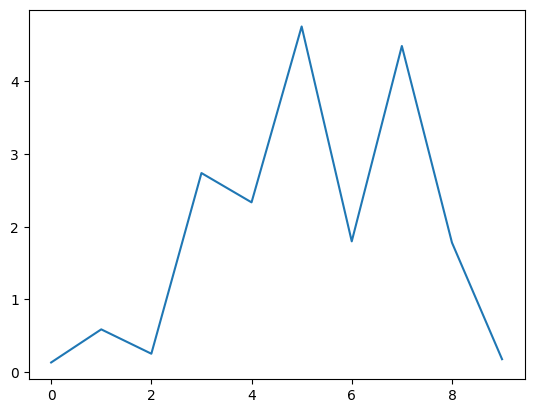

In [82]:
liste_error = []
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    criterion(tpdn_output[:,i,:], rnn_out[:,i,:]).detach().numpy()
    liste_error.append(criterion(tpdn_output[:,i,:], rnn_out[:,i,:]).item())

plt.plot(liste_error)